# Benchmarking Qmachines with different RB protocols

In [1]:
!pip install tqdm

In [2]:
from RB_stabilizer_verification import machine_response_stabilizer_bench
from RB_standard_verification import machine_response_standard_bench
from RB_with_Rigetti_native_gates import machine_response_srb_native_gate
from RB_standard_verification_with_arbitrary_random_unitaries import machine_response_standard_bench_random_units
from functions import averageOfFidelity

In [3]:
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
k_m = 10
n_m = 10
n_qubit = 2
max_layer_num = 8
avg_std_fdlty_list = []
avg_stab_fdlty_list = []
avg_rng_fdlty_list = []
avg_runitary_fdlty_list = []

## RB standard version (with Clifford set)

In [5]:
for m in tqdm(range(1,max_layer_num+1)):
    avg_std_fdlty_list.append( averageOfFidelity(machine_response_standard_bench(n_qubit, m, k_m, n_m)) )
    

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:12<00:00,  6.33s/it]


Text(0, 0.5, 'Average of Fidelity')

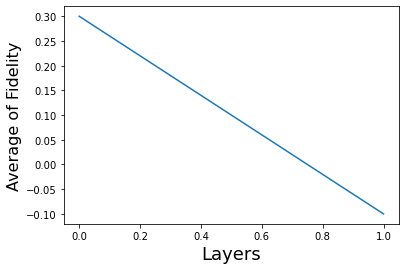

In [6]:
plt.plot(avg_std_fdlty_list)
plt.xlabel('Layers', fontsize=18)
plt.ylabel('Average of Fidelity', fontsize=16)

## RB stabilizer version (with Clifford set)

In [7]:
for m in tqdm(range(1,max_layer_num+1)):
    avg_stab_fdlty_list.append( averageOfFidelity(machine_response_stabilizer_bench(n_qubit, m, k_m, n_m)) )

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.26s/it]


Text(0, 0.5, 'Average of Fidelity')

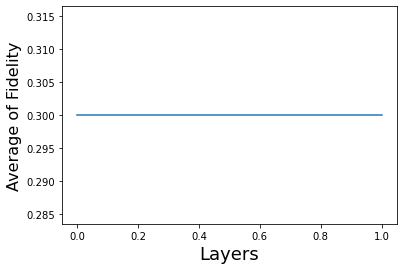

In [8]:
plt.plot(avg_stab_fdlty_list)
plt.xlabel('Layers', fontsize=18)
plt.ylabel('Average of Fidelity', fontsize=16)

## RB standard version (with Riggetti native gate set)

In [9]:
for m in tqdm(range(1,max_layer_num+1)):
    avg_rng_fdlty_list.append(averageOfFidelity(machine_response_srb_native_gate(n_qubit, m, k_m, n_m)))

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.68s/it]


Text(0, 0.5, 'Average of Fidelity')

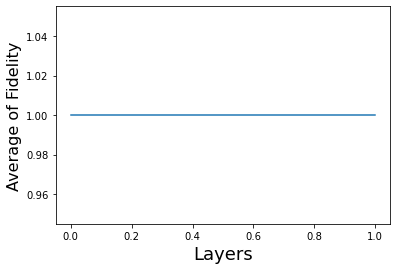

In [10]:
plt.plot(avg_rng_fdlty_list)
plt.xlabel('Layers', fontsize=18)
plt.ylabel('Average of Fidelity', fontsize=16)

## RB standard version (with arbitary random unitary set)

In [11]:
for m in tqdm(range(1,max_layer_num+1)):
    avg_runitary_fdlty_list.append(averageOfFidelity(machine_response_standard_bench_random_units(n_qubit, m, k_m, n_m)))

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.54s/it]


Text(0, 0.5, 'Average of Fidelity')

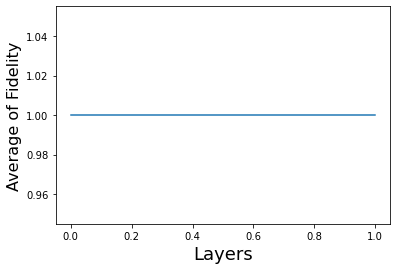

In [12]:
plt.plot(avg_runitary_fdlty_list)
plt.xlabel('Layers', fontsize=18)
plt.ylabel('Average of Fidelity', fontsize=16)